# Import

In [16]:
import pandas as pd
import glob
import os

In [ ]:
# --- Configuration ---
# Set the base directory where the 'perf_*' folders are located.
# Use '.' for the current directory.
base_directory = "./"
# -------------------

In [18]:
# Construct the search pattern for CSV files
# This looks for any directory starting with 'perf_' within the base_directory,
# and then any CSV file starting with 'perf_' inside that directory.
search_pattern = os.path.join(base_directory, "perf_*", "perf_*.csv")

# Find all file paths matching the pattern
csv_files = glob.glob(search_pattern)

if not csv_files:
    print(f"Error: No CSV files found matching the pattern '{search_pattern}'")
    print("Please ensure the script is run from the correct parent directory")
    print("or update the 'base_directory' variable in the script.")
else:
    print(f"Found {len(csv_files)} CSV files:")
    for f in csv_files:
        print(f" - {f}")

    # List to store individual DataFrames before concatenation
    dataframe_list = []

    # Loop through each found CSV file path
    for file_path in csv_files:
        try:
            # Extract the implementation name from the directory path
            # Example: './perf_CAS/perf_CAS_....csv' -> 'perf_CAS'
            directory_path = os.path.dirname(file_path)
            # Example: 'perf_CAS'
            directory_name = os.path.basename(directory_path)
            # Example: 'CAS' (split 'perf_CAS' at '_' and take the second part)
            implementation_name = directory_name.split("_", 1)[1]

            # Read the current CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)

            # Add the 'implementation' column
            df["implementation"] = implementation_name

            # Add the processed DataFrame to our list
            dataframe_list.append(df)

        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
        except pd.errors.EmptyDataError:
            print(f"Warning: File {file_path} is empty. Skipping.")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Concatenate all DataFrames in the list into a single DataFrame
    if dataframe_list:
        combined_df = pd.concat(dataframe_list, ignore_index=True)

        print("\nSuccessfully combined data into a single DataFrame.")
        print("\nDataFrame Info:")
        combined_df.info()

        print("\nFirst 5 rows of the combined data:")
        print(combined_df.head())

        print("\nLast 5 rows of the combined data:")
        print(combined_df.tail())

        print("\nData count per implementation:")
        print(combined_df["implementation"].value_counts())

        # You can now work with the 'combined_df' DataFrame for analysis and visualization
        # For example: combined_df.to_csv('combined_perf_data.csv', index=False)

    else:
        print("\nNo dataframes were loaded. The combined DataFrame is empty.")

# The 'combined_df' variable now holds the merged data (if any files were processed).

Found 3 CSV files:
 - phuocthanh_latitude/counter/perf_MB/perf_MB_20250326_112501.csv
 - phuocthanh_latitude/counter/perf_CAS/perf_CAS_20250326_113210.csv
 - phuocthanh_latitude/counter/perf_FAD/perf_FAD_20250326_113513.csv

Successfully combined data into a single DataFrame.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   threads            75 non-null     int64 
 1   iterations         75 non-null     int64 
 2   counter_targets    75 non-null     int64 
 3   execution_time_ms  75 non-null     int64 
 4   success            75 non-null     bool  
 5   implementation     75 non-null     object
dtypes: bool(1), int64(4), object(1)
memory usage: 3.1+ KB

First 5 rows of the combined data:
   threads  iterations  counter_targets  execution_time_ms  success  \
0        1        1000            32000               1154    

# Plotting

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

Setting X-axis ticks for threads to: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16)]
Using log base 2 scale for X-axis.

Generating Plot 1: Faceted by Counter Target...


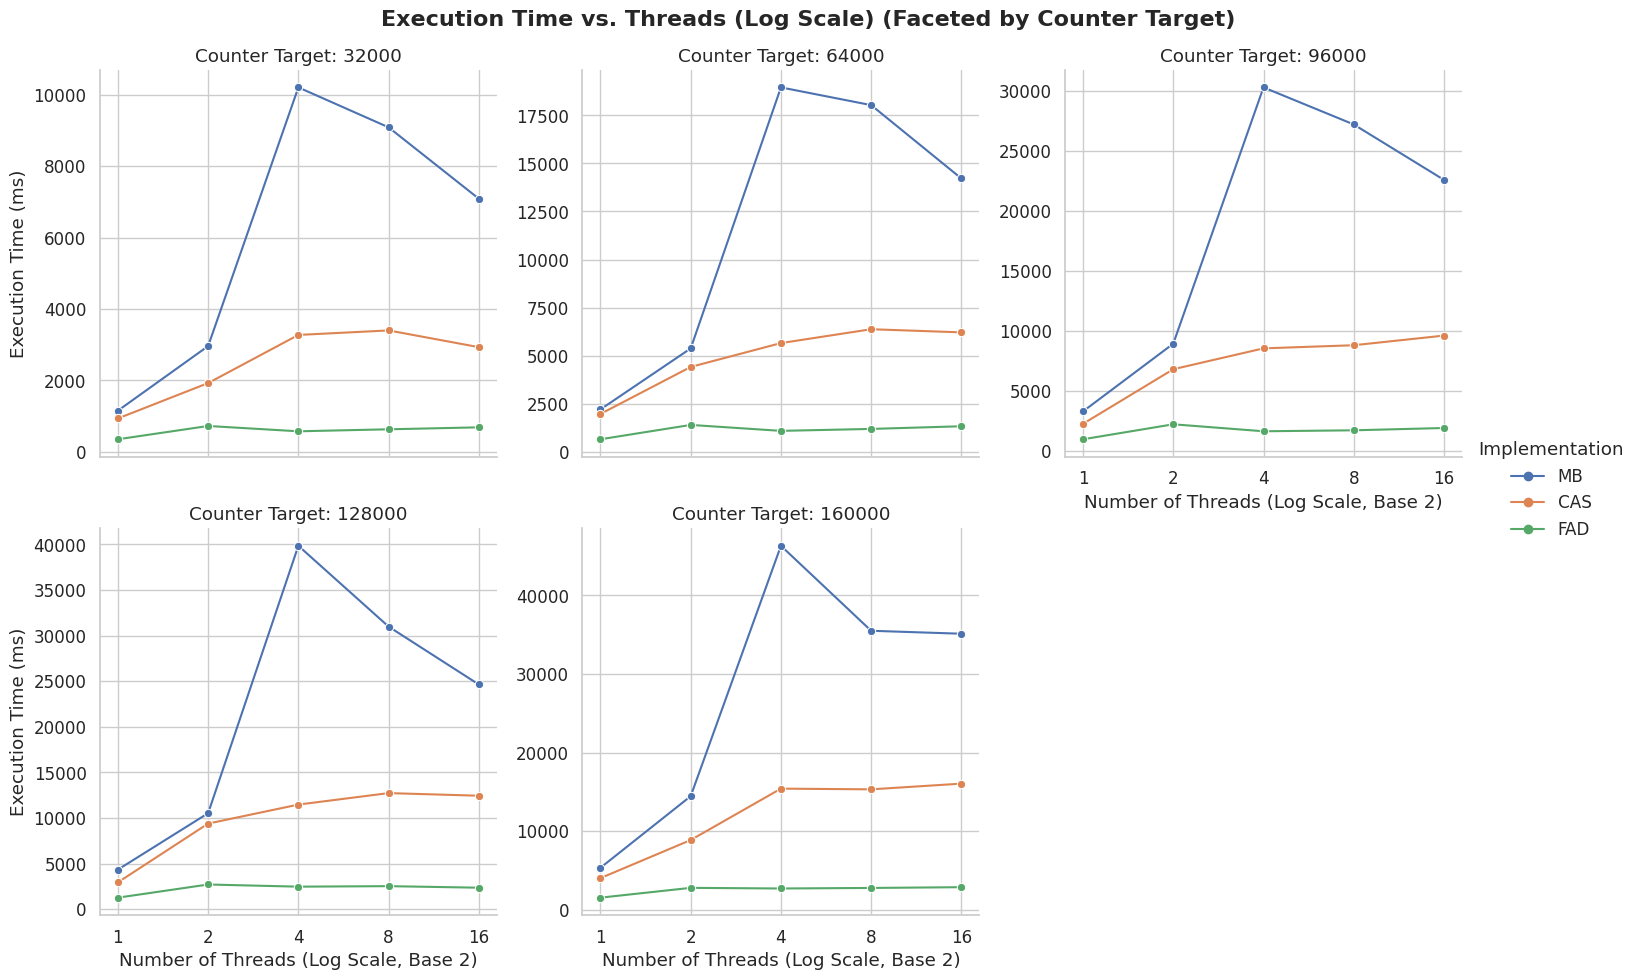

In [20]:
# --- Determine desired X-axis ticks from data ---
thread_ticks = sorted(combined_df["threads"].unique())
print(f"Setting X-axis ticks for threads to: {thread_ticks}")
print("Using log base 2 scale for X-axis.")

# --- Plot Configuration ---
sns.set_theme(style="whitegrid", font_scale=1.1)
share_y_axis_plot1 = False
share_y_axis_plot2 = False

# --- Plot 1: Facet by Counter Target (Compare Implementations within each workload) ---
print("\nGenerating Plot 1: Faceted by Counter Target...")

g1 = sns.relplot(
    data=combined_df,
    kind="line",
    x="threads",
    y="execution_time_ms",
    hue="implementation",
    col="counter_targets",
    col_wrap=3,
    marker="o",
    facet_kws={"sharey": share_y_axis_plot1},
)

# --- Customize Plot 1 ---
g1.fig.subplots_adjust(top=0.92)
g1.fig.suptitle(
    "Execution Time vs. Threads (Log Scale) (Faceted by Counter Target)",
    fontsize=16,
    weight="bold",
)
g1.set_axis_labels(
    "Number of Threads (Log Scale, Base 2)", "Execution Time (ms)"
)  # Updated Axis Label
g1.set_titles(col_template="Counter Target: {col_name}")
if g1.legend:
    g1.legend.set_title("Implementation")

# --->>> Set log scale and specific ticks for x-axis <<<---
for ax in g1.axes.flat:
    if ax.has_data():
        # 1. Set log scale (base 2) FIRST
        ax.set_xscale("log", base=2)
        # 2. Set specific ticks on the log scale using original values
        ax.set_xticks(thread_ticks)
        # 3. Set labels for those ticks using original values
        # Use ScalarFormatter if default labels look odd, but usually fine for powers of 2
        ax.set_xticklabels(thread_ticks)

# Show the first plot
plt.show()


Generating Plot 2: Faceted by Implementation...


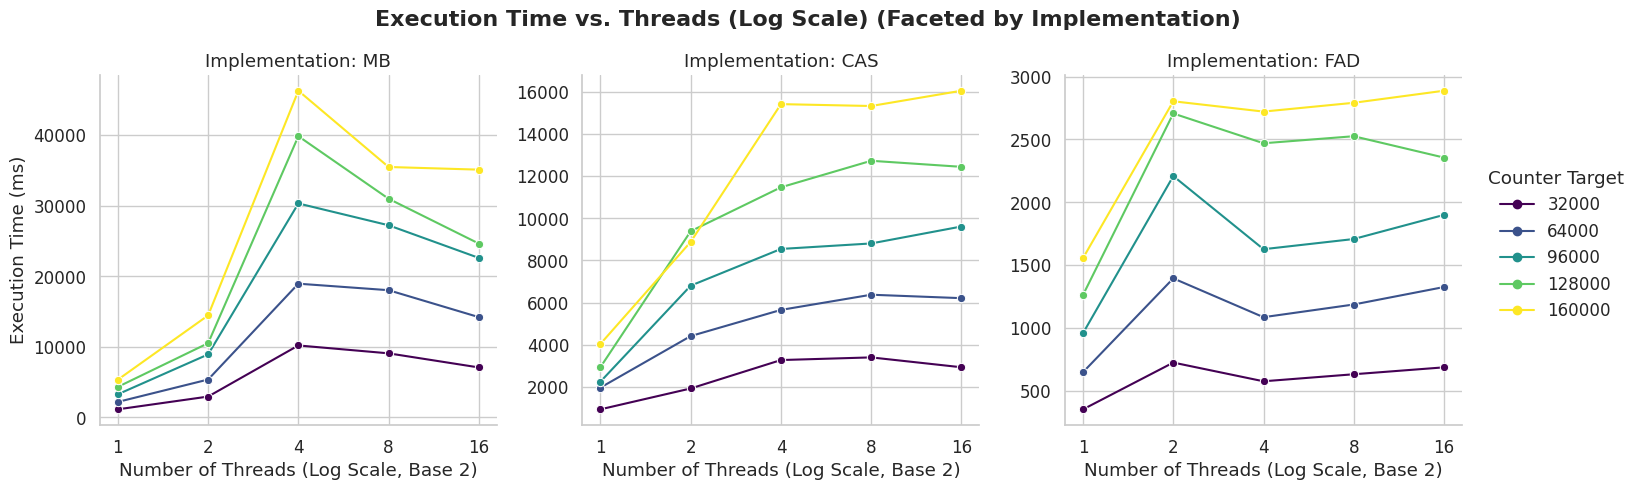


Plot generation complete.


In [21]:
# --- Plot 2: Facet by Implementation (Compare Workloads within each implementation) ---
print("\nGenerating Plot 2: Faceted by Implementation...")

g2 = sns.relplot(
    data=combined_df,
    kind="line",
    x="threads",
    y="execution_time_ms",
    hue="counter_targets",
    palette="viridis",
    col="implementation",
    col_wrap=3,
    marker="o",
    facet_kws={"sharey": share_y_axis_plot2},
)

# --- Customize Plot 2 ---
g2.fig.subplots_adjust(top=0.85)
g2.fig.suptitle(
    "Execution Time vs. Threads (Log Scale) (Faceted by Implementation)",
    fontsize=16,
    weight="bold",
)
g2.set_axis_labels(
    "Number of Threads (Log Scale, Base 2)", "Execution Time (ms)"
)  # Updated Axis Label
g2.set_titles(col_template="Implementation: {col_name}")
try:
    if g2.legend:
        g2.legend.set_title("Counter Target")
except AttributeError:
    print("Note: Legend not generated for Plot 2 (possibly only one counter_target level present).")

# --->>> Set log scale and specific ticks for x-axis <<<---
for ax in g2.axes.flat:
    if ax.has_data():
        # 1. Set log scale (base 2) FIRST
        ax.set_xscale("log", base=2)
        # 2. Set specific ticks
        ax.set_xticks(thread_ticks)
        # 3. Set labels
        ax.set_xticklabels(thread_ticks)

# Show the second plot
plt.show()

print("\nPlot generation complete.")